In [1]:
from openai import OpenAI
import ast
import json
import pandas as pd
from IPython import display
from sklearn.model_selection import train_test_split
from pydantic import BaseModel
from tqdm import tqdm

In [2]:
MODEL="gpt-4o-2024-08-06"
openai_api_key =  ""

In [3]:
class ClassificationResponse(BaseModel):
    Classification: int  # Expecting an integer output (1 or 0)

In [4]:
train = pd.read_csv("../data/train_v2_400.csv")
train_patient = train[train["label"] == 1]
train_control = train[train["label"] == 0]

test = pd.read_csv("../data/test_v2_149.csv")
test["GPT_response"] = pd.NA
test["GPT_label"] = pd.NA
test["example_index"] = pd.NA

In [5]:
test.head()

,index,label,line,GPT_response,GPT_label,example_index
0,307,0,INV: what do you see going on in that picture?...,<NA>,<NA>,<NA>
1,320,0,PAR: okay.\nPAR: there's a little boy.\nPAR: a...,<NA>,<NA>,<NA>
2,326,0,PAR: alright?\nINV: mhm.\nPAR: mother's doing ...,<NA>,<NA>,<NA>
3,327,0,INV: okay good.\nINV: tell me all of the thing...,<NA>,<NA>,<NA>
4,343,0,PAR: what's going on?\nPAR: okay.\nPAR: uh mot...,<NA>,<NA>,<NA>


In [6]:
client = OpenAI(api_key = openai_api_key)

In [7]:
def openai_ask(patient, control, text):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": "Classify the cognitive state from the dialogue."},
            {"role": "user", "content": (
                "You are an expert language model trained to identify cognitive impairments based on dialogue analysis. "
                "Your task is to classify a given dialogue as belonging to either a patient with Alzheimer’s Disease (AD), "
                "Mild Cognitive Impairment (MCI), or a healthy older adult. Please analyze the provided dialogue based on the ten examples and return "
                "one of the following outputs:\n"
                "- Return `1` if the dialogue suggests cognitive impairment (AD or MCI).\n"
                "- Return `0` if the dialogue suggests a healthy older adult.\n\n"
                f"Here are five sample dialogues from cognitive impairment patients:\n{patient}\n\n"
                f"Here are five sample dialogues from healthy older adults:\n{control}\n\n"
                f"And now please identify this dialogue:\n{text}\n\n"
                "Output should be a single number: `1` or `0`."
            )}
        ],
        response_format=ClassificationResponse,  # Using the pydantic model directly for structured output
        temperature=0.0,
    )
    return response.choices[0].message.content

In [8]:
test.head()

,index,label,line,GPT_response,GPT_label,example_index
0,307,0,INV: what do you see going on in that picture?...,<NA>,<NA>,<NA>
1,320,0,PAR: okay.\nPAR: there's a little boy.\nPAR: a...,<NA>,<NA>,<NA>
2,326,0,PAR: alright?\nINV: mhm.\nPAR: mother's doing ...,<NA>,<NA>,<NA>
3,327,0,INV: okay good.\nINV: tell me all of the thing...,<NA>,<NA>,<NA>
4,343,0,PAR: what's going on?\nPAR: okay.\nPAR: uh mot...,<NA>,<NA>,<NA>


In [9]:
for idx, row in tqdm(test.iterrows(), total=test.shape[0]):
    patient_tmp = train_patient.sample(5)
    control_tmp = train_control.sample(5)
    example_index = list(patient_tmp.index) + list(control_tmp.index)

    patient_text = patient_tmp.line
    patient_text = "\n\n".join(f"{i+1}.\n{string}" for i, string in enumerate(patient_text))

    control_text = control_tmp.line
    control_text = "\n\n".join(f"{i+1}.\n{string}" for i, string in enumerate(control_text))

    test.at[idx, "GPT_response"] = openai_ask(patient_text, control_text, row["line"])
    test.at[idx, "example_index"] = example_index

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [01:25<00:00,  1.74it/s]


In [15]:
test.to_csv("../data/gpt_response_10_shot.csv")

In [11]:
for idx, row in tqdm(test.iterrows(), total=test.shape[0]):
    test.at[idx, "GPT_label"] = int(ast.literal_eval(row["GPT_response"])["Classification"])
test["GPT_label"] = test["GPT_label"].astype(int)


  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 15673.94it/s]


Accuracy: 0.6375838926174496


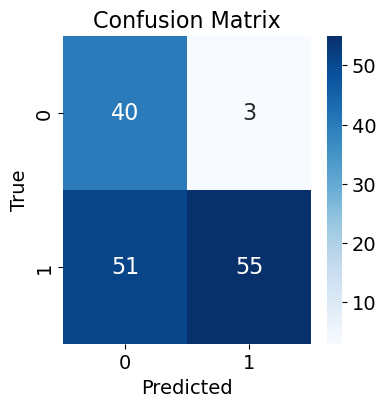

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", (test["label"] == test["GPT_label"]).mean())
cm = confusion_matrix(test["label"], test["GPT_label"])
plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 14})
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [110]:
df.to_csv("../data/gpt_response_first_try.csv")